# **PyTorch JIT Optimization**
License : CC BY-NC-SA 4.0

---
---
## **Introduction**

Welcome to our lab on optimizing deep learning models with PyTorch's JIT compilation, focusing on TorchScript and `torch.compile`. Dive into hands-on applications of these core optimization tools to boost model performance efficiently.

**Lab Objectives:**
- Understand interpretation vs. compilation in Python and PyTorch.
- Master TorchScript through tracing and scripting for JIT compilation.
- Explore `torch.compile` to optimize PyTorch models effectively.
- Practice exporting models for efficient deployment.


**Why JIT?** JIT compilation optimizes PyTorch models by compiling Python code into a more efficient form at runtime, enhancing execution speed and resource efficiency. This is crucial for:
- Accelerating execution and reducing resource demands.
- Improving hardware utilization.
- Simplifying deployment across diverse platforms.


This lab explores JIT compilation in PyTorch, showing how it addresses Python's limitations to enhance deep learning model performance, and equips you with techniques to optimize your models.

---
---
## **Initial Setup and Instructions**
This section prepares the notebook environment for our exercises and introduces key tools we'll use throughout.

### Understanding `ToDo`

Throughout this notebook, you'll encounter placeholders marked with `ToDo`. This indicates a section where you, the student, need to complete or modify the code. The `ToDo` class is designed to remind you of tasks that need to be addressed to proceed with the exercises. It's a prompt for active participation in the learning process.

Whenever you see a `ToDo` in the code, it's your cue to engage with the material by writing or modifying code. This interactive approach helps reinforce learning through practice.

The following cell defines the `ToDo` class. Note that no action is required from you in this specific cell; it's simply a setup for the interactive tasks ahead.

In [3]:
class ToDo:
    def __init__(self, message=None):
        if message is None:
            self.message = "This part of the code needs to be completed by the student."
        else:
            self.message = message

    def __call__(self, *args, **kwargs):
        print("TODO: Complete this part of the code.")
        raise NotImplementedError(self.message)

    # Example of an additional method that could be useful in the future
    def hint(self):
        print(f"Hint: {self.message}")

# Usage
todo = ToDo()

### Executing Lab Exercises: Interactive and Script-Based Tasks

Throughout this lab, you'll engage in exercises directly within this notebook and work on script-based tasks identifiable by `%writefile` at the beginning of the cell. For deploying scripts on a computing cluster, leverage `srun` to execute your code on compute nodes. If you're equipped with a local GPU, run these scripts using `!python code.py`. This dual approach ensures a thorough learning experience, combining interactive exploration with practical script execution.

### Auto-Reloading

To ensure any changes in imported modules are automatically updated in the notebook, we enable auto-reloading. This is particularly useful during development, as it saves time that would otherwise be spent restarting the kernel.


In [4]:
%load_ext autoreload
%autoreload 2


### Initial Setup

Before starting, create a `generated_files` directory to ensure all generated script files are neatly stored in one place.

Also we import utilitary functions to run jobs.

> **Task:** Define a name you will use to identify your jobs

In [5]:
!mkdir -p generated_files

In [7]:
from idr_pytools import display_slurm_queue, gpu_jobs_submitter, search_log
from dlojz_tools import controle_technique, compare, GPU_underthehood, plot_accuracy, lrfind_plot, imagenet_starter, turbo_profiler
MODULE = 'pytorch-gpu/py3/2.1.1'
account = 'sos@a100'
name = 'kg'   ## Pseudonyme à choisir

---
---
## **Python's Execution Model Explained**

Python, an interpreted language, processes code line by line, which is straightforward for development but can slow down execution. Unlike compiled languages like C, which convert code directly into machine code for faster performance, Python's execution involves an extra step that can introduce performance bottlenecks.

### CPython's Hybrid Approach

CPython, Python's standard interpreter, compiles code to bytecode before interpreting it, striking a balance between direct interpretation and full compilation. This method reduces some overhead but doesn't achieve the full speed of compiled languages.

### Boosting Performance with Cython

Cython enhances Python by allowing static typing and compilation to C, significantly speeding up execution. This approach bridges the gap between Python's ease of use and the performance of compiled languages, albeit with the complexity of managing Cython code and the limitations in handling dynamic operations.

### JIT in PyTorch

PyTorch addresses Python's performance issues with JIT compilation, converting code into an optimized, hardware-specific format at runtime. This method ensures efficient execution of dynamic deep learning models, leveraging the best of both Python's flexibility and the efficiency of compiled execution.

Through JIT, PyTorch marries Python's development advantages with the performance benefits of compiled languages, optimizing deep learning model performance and deployment.


---
---
## **Performance: Python vs. C**


Python runs code directly, which is beneficial for rapid development but can result in slower execution times. Conversely, C requires a compilation process that translates code into a binary executable, typically leading to faster execution after this initial setup. The C compilation process involves:

1. **Preprocessing:** Macro expansion and inclusion of header files.
2. **Compilation:** Conversion of the preprocessed source code to assembly code.
3. **Assembly:** Translation of assembly code into machine code, producing an object file (.o).
4. **Linking:** Combining object files and libraries into a final executable binary.

### Tasks

> **Task 1 (Python)**: Create a Python script to sum numbers from 1 to 1 million. Then, time the script's execution.
<details>
<summary>Solution (click to reveal)</summary>

Here's one way to solve the exercise using a loop, encapsulated within a Python script file stored in the `generated_files` directory:

```python
%%writefile generated_files/sum_python.py
total = 0
for i in range(1, 1000001):
    total += i
print(f"Sum: {total}")
```

Alternatively, for a more concise solution using Python's built-in `sum()` function, also stored in the `generated_files` directory:

```python
%%writefile generated_files/sum_python.py
total = sum(range(1, 1000001))
print(f"Sum: {total}")
```

Both scripts, when executed, will calculate the sum of numbers from 1 to 1,000,000 and are stored in the `generated_files` directory for organization.

</details>

> **Task 2 (C)**: Create a C program to sum numbers from 1 to 1 million. Compile and time the program's execution.
<details>
<summary>Solution (click to reveal)</summary>

Here's a solution for summing numbers from 1 to 1,000,000 using a loop, encapsulated within a C program file stored in the `generated_files` directory:

```c
%%writefile generated_files/sum_c.c
#include <stdio.h>

int main() {
    long total = 0;
    for (int i = 1; i <= 1000000; i++) {
        total += i;
    }

    printf("Sum: %ld\n", total);
    return 0;
}
```

This script, when compiled and executed, will calculate the sum of numbers from 1 to 1,000,000 and is stored in the `generated_files` directory for tidy organization.

</details>

> **Task 3 (Comparison)**: Compare the execution times of both programs. Reflect on the differences and discuss the impact of Python's direct execution versus the compilation and execution process of C.

<details>
<summary>Solution (click to reveal)</summary>


Observations from the execution times:

1. **Python's Execution**: Directly interpreted, resulting in slower execution due to real-time interpretation overhead.
```
real	0m0.073s
user	0m0.039s
 sys	0m0.020s
```

2. **C's Execution**: Involves compilation and running. The compilation is a one-time overhead, but the resulting executable runs significantly faster than the Python script.
```
real	0m0.377s
user	0m0.034s
 sys	0m0.082s

real	0m0.013s
user	0m0.004s
 sys	0m0.009s
```

    
### Conclusion:

The key difference lies in Python's runtime interpretation versus C's upfront compilation. C's compiled executable runs faster, showcasing the efficiency of compiled programs despite the initial compile time.

</details>



These tasks illustrate performance differences between Python and C. If you're less familiar with these languages, it's okay to focus on the conceptual insights. **The key is understanding, not perfect execution.**

In [94]:
%%writefile generated_files/sum_python.py
total = 0
for i in range(1, 1000001):
    total += i
print(f"Sum: {total}")

Overwriting generated_files/sum_python.py


In [95]:
%%writefile generated_files/sum_python.py
total = sum(range(1, 1000001))
print(f"Sum: {total}")

Overwriting generated_files/sum_python.py


In [97]:
%%writefile generated_files/sum_c.c
#include <stdio.h>

int main() {
    long total = 0;
    for (int i = 1; i <= 1000000; i++) {
        total += i;
    }

    printf("Sum: %ld\n", total);
    return 0;
}

Overwriting generated_files/sum_c.c


In [98]:
print("Python performance:")
!time python generated_files/sum_python.py
print("\n\nC performance compilation:")
!time gcc generated_files/sum_c.c -o generated_files/sum_c
print("\n\nC performance execution:")
!time ./generated_files/sum_c

Python performance:
Sum: 500000500000

real	0m0.120s
user	0m0.040s
sys	0m0.024s


C performance compilation:

real	0m0.242s
user	0m0.030s
sys	0m0.079s


C performance execution:
Sum: 500000500000

real	0m0.019s
user	0m0.003s
sys	0m0.010s


---
---
## **TorchScript**

### JIT (Just-In-Time) Compilation

JIT compilation optimizes PyTorch model execution, translating Python code to a more efficient format that enhances performance, particularly during inference. It combines Python's development simplicity with the execution speed closer to compiled languages.


### TorchScript Mechanism

TorchScript is a tool within PyTorch for creating serializable and optimizable models. It enables models to run independently of Python, facilitating deployment in non-Python environments.

- **Mechanism**: Converts PyTorch models to TorchScript through **tracing** or **scripting**.
  
  - **Tracing** records operations on provided inputs, generating a computation graph.
  
  - **Scripting** directly translates Python code to TorchScript, incorporating complex control flows.

#### Advantages
- **Improved Performance**: Models execute faster, especially in production.
- **Increased Portability**: Enables model execution in environments without Python.
- **Enhanced Flexibility**: Supports models with dynamic behaviors and varying inputs.

TorchScript is pivotal for JIT in PyTorch, improving models' speed, deployability, and flexibility.

Before diving into specifics, let's outline our approach: we'll first explore TorchScript's key features—tracing and scripting—to understand how they convert Python functions for optimized execution in PyTorch. After grasping these functionalities, we will then evaluate the performance gains they offer.

### Exploring TorchScript Tracing



TorchScript tracing transforms Python functions into TorchScript by executing the function with a sample input and capturing the operations executed. This creates a static computation graph reflecting the input-specific behavior. While tracing suits straightforward functions well, it may not accurately handle dynamic behavior due to its static nature.


> **Task: Implement Tracing with TorchScript for `add_ten` and `conditional_add` by using torch.jit.trace.** Refer to the [torch.jit.trace documentation](https://pytorch.org/docs/stable/generated/torch.jit.trace.html#torch.jit.trace) for more details on the parameters required.



<details>
<summary>Solution (click to reveal)</summary>
Unlike tracing, scripting does not require an example input. Scripting analyzes the code to capture control flows and the overall logic.
 
```python
import torch

# Define the functions
def add_ten(x):
    return x + 10

def conditional_add(x):
    if x < 10:
        x = x + 10
    else:
        x = x + 100
    return x

# Apply tracing
example_input = torch.tensor(1)
traced_add_ten = torch.jit.trace(add_ten, example_input)
traced_conditional_add = torch.jit.trace(conditional_add, example_input)
```
</details>

In [100]:
import torch

# Define the functions
def add_ten(x):
    return x + 10

def conditional_add(x):
    if x < 10:
        x = x + 10
    else:
        x = x + 100
    return x

# Apply tracing
example_input = torch.tensor(1)
traced_add_ten = torch.jit.trace(add_ten, example_input)
traced_conditional_add = torch.jit.trace(conditional_add, example_input)

/tmp/ipykernel_2984286/1385163837.py:8: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x < 10:



> **Task: Observe Results and Discuss Tracing Limitations for `conditional_add`**. Experiment with `traced_add_ten` and `traced_conditional_add` using various inputs. Specifically, adjust the example input for `traced_conditional_add` and note the changes.

<details>
<summary>Solution (click to reveal)</summary>

```
Traced 'add_ten' result: tensor(10)
Traced 'add_ten' result: tensor(25)
Traced 'conditional_add' with input less than 10: tensor(10)
Traced 'conditional_add' with input greater than 10: tensor(25)
```
    
`traced_add_ten` consistently adds ten to any input, reflecting its straightforward logic. In contrast, `traced_conditional_add` may fail to adapt to inputs not matched by the example input used for tracing. This is because tracing captures the function's execution path based on that specific input, missing other conditional branches.

Changing the example input for tracing `conditional_add` directly impacts which conditional path is captured. For example, tracing with a value less than 10 captures the "less than 10" path, making the function inaccurate for inputs greater than 10, and vice versa.

This demonstrates tracing's limitation with dynamic behaviors, emphasizing the need for a representative example input to ensure accurate behavior across all inputs.
</details>

In [101]:
# Test the traced functions
test_input_less = torch.tensor(0)
test_input_more = torch.tensor(15)

print("Traced 'add_ten' result:", traced_add_ten(test_input_less))
print("Traced 'add_ten' result:", traced_add_ten(test_input_more))
print("Traced 'conditional_add' with input less than 10:", traced_conditional_add(test_input_less))
print("Traced 'conditional_add' with input greater than 10:", traced_conditional_add(test_input_more))

Traced 'add_ten' result: tensor(10)
Traced 'add_ten' result: tensor(25)
Traced 'conditional_add' with input less than 10: tensor(10)
Traced 'conditional_add' with input greater than 10: tensor(25)


> **Task: Compare the Graphs for `add_ten` and `conditional_add` Tracing** generated using the `.graph` attribute of the traced objects. This attribute provides a textual representation of the operations and tensors within the traced function, showcasing the flow of data and the operations applied.

<details>
<summary>Solution (click to reveal)</summary>

```
Graph for 'add_ten':
 graph(%x : Long(requires_grad=0, device=cpu)):
  %1 : Long(requires_grad=0, device=cpu) = prim::Constant[value={10}]() # /tmp/ipykernel_3336442/1385163837.py:5:0
  %2 : int = prim::Constant[value=1]() # /tmp/ipykernel_3336442/1385163837.py:5:0
  %3 : Long(requires_grad=0, device=cpu) = aten::add(%x, %1, %2) # /tmp/ipykernel_3336442/1385163837.py:5:0
  return (%3)


Graph for 'conditional_add':
 graph(%x : Long(requires_grad=0, device=cpu)):
  %3 : Long(requires_grad=0, device=cpu) = prim::Constant[value={10}]() # /tmp/ipykernel_3336442/1385163837.py:9:0
  %4 : int = prim::Constant[value=1]() # /tmp/ipykernel_3336442/1385163837.py:9:0
  %5 : Long(requires_grad=0, device=cpu) = aten::add(%x, %3, %4) # /tmp/ipykernel_3336442/1385163837.py:9:0
  return (%5)
```

    
The traced graphs for `add_ten` and `conditional_add` are structurally similar, highlighting tracing's static nature. Despite `conditional_add`'s conditional logic, its graph shows a straightforward addition, like `add_ten`, underscoring tracing's limitation in capturing dynamic behavior based solely on the provided example input.

</details>

In [102]:
print("Graph for 'add_ten':\n", traced_add_ten.graph)
print("\nGraph for 'conditional_add':\n", traced_conditional_add.graph)

Graph for 'add_ten':
 graph(%x : Long(requires_grad=0, device=cpu)):
  %1 : Long(requires_grad=0, device=cpu) = prim::Constant[value={10}]() # /tmp/ipykernel_2984286/1385163837.py:5:0
  %2 : int = prim::Constant[value=1]() # /tmp/ipykernel_2984286/1385163837.py:5:0
  %3 : Long(requires_grad=0, device=cpu) = aten::add(%x, %1, %2) # /tmp/ipykernel_2984286/1385163837.py:5:0
  return (%3)


Graph for 'conditional_add':
 graph(%x : Long(requires_grad=0, device=cpu)):
  %3 : Long(requires_grad=0, device=cpu) = prim::Constant[value={10}]() # /tmp/ipykernel_2984286/1385163837.py:9:0
  %4 : int = prim::Constant[value=1]() # /tmp/ipykernel_2984286/1385163837.py:9:0
  %5 : Long(requires_grad=0, device=cpu) = aten::add(%x, %3, %4) # /tmp/ipykernel_2984286/1385163837.py:9:0
  return (%5)



### Exploring TorchScript Scripting



After exploring TorchScript's tracing mechanism, let's delve into scripting, another powerful method for converting Python functions and models into TorchScript.

Scripting performs a static analysis of your Python code to create a TorchScript version. Unlike tracing, which records operations performed on example inputs, scripting examines the code itself, capturing its structure, control flows (like loops and if-statements), and the overall logic.

**Advantages Over Tracing:**

- **Dynamic Behavior**: Scripting accurately captures dynamic behaviors, making it more suitable for functions and models with conditional logic or varying execution paths.
- **Complete Translation**: It translates the entire function or model, including all potential execution paths, not just the ones executed with a particular set of example inputs.

**Weaknesses:**
- **Compatibility**: Not all Python code is directly convertible to TorchScript via scripting. Certain Python features, especially those involving dynamic typing or reflection, might not be supported.
- **Complexity**: Understanding errors and debugging the scripted code can be more challenging due to the static analysis and the need to adhere strictly to TorchScript's supported features.

To solidify your understanding of TorchScript scripting, you'll convert functions to TorchScript using scripting, observe their behavior, and identify both the strengths and limitations of scripting.


> **Task: Convert the previously defined `add_ten` and `conditional_add` functions to TorchScript using torch.jit.script.** Refer to the [torch.jit.script documentation](https://pytorch.org/docs/stable/generated/torch.jit.script.html#torch.jit.script) for more details on the parameters required.


<details>
<summary>Solution (click to reveal)</summary>

Unlike tracing, scripting does not require an example input. Scripting analyzes the code to capture control flows and the overall logic.

```python
# Apply scripting
scripted_add_ten = torch.jit.script(add_ten)
scripted_conditional_add = torch.jit.script(conditional_add)
```
</details>

In [104]:
import torch
scripted_add_ten = torch.jit.script(add_ten)
scripted_conditional_add = torch.jit.script(conditional_add)


> **Task: Test and Analyze Scripted Functions** with different inputs. Observe how the scripted versions handle different scenarios compared to their traced counterparts, especially for `conditional_add`.

<details>
<summary>Solution (click to reveal)</summary>

```
Scripted 'conditional_add' with input less than 10: tensor(15)
Scripted 'conditional_add' with input greater than 10: tensor(115)
```
    
Testing the scripted functions with various inputs demonstrates that they accurately reflect the original Python logic, producing correct results for all scenarios, unlike their traced counterparts which may not capture dynamic behaviors effectively.

</details>

In [105]:
print("Scripted 'conditional_add' with input less than 10:", scripted_conditional_add(torch.tensor(5)))
print("Scripted 'conditional_add' with input greater than 10:", scripted_conditional_add(torch.tensor(15)))

Scripted 'conditional_add' with input less than 10: tensor(15)
Scripted 'conditional_add' with input greater than 10: tensor(115)


> **Task: Compare the Graphs for `add_ten` and `conditional_add` Scripting** generated using the `.graph` attribute of the scripted objects. This attribute provides a textual representation of the operations and tensors within the scripted function, showcasing the flow of data and the operations applied. Reflect on scripting's ability to accurately represent the original Python function, regardless of input variability. Contrast this with your observations from tracing, particularly for the `conditional_add` function.

<details>
<summary>Solution (click to reveal)</summary>
    
The `.graph` attribute of the scripted `add_ten` and `conditional_add` functions reveals TorchScript's ability to closely mirror the original Python code's logic. Unlike tracing, scripting captures conditional branches and dynamic behaviors accurately, ensuring the scripted functions behave as intended across different inputs. This direct representation highlights scripting's superiority in handling complex, input-dependent logic, a stark contrast to the limitations observed with tracing.

```
Graph for 'add_ten':
 graph(%x.1 : Tensor):
  %3 : int = prim::Constant[value=1]()
  %2 : int = prim::Constant[value=10]() # /tmp/ipykernel_3336442/1385163837.py:5:15
  %4 : Tensor = aten::add(%x.1, %2, %3) # /tmp/ipykernel_3336442/1385163837.py:5:11
  return (%4)


Graph for 'conditional_add':
 graph(%x.1 : Tensor):
  %7 : int = prim::Constant[value=1]()
  %2 : int = prim::Constant[value=10]() # /tmp/ipykernel_3336442/1385163837.py:8:11
  %11 : int = prim::Constant[value=100]() # /tmp/ipykernel_3336442/1385163837.py:11:16
  %3 : Tensor = aten::lt(%x.1, %2) # /tmp/ipykernel_3336442/1385163837.py:8:7
  %5 : bool = aten::Bool(%3) # /tmp/ipykernel_3336442/1385163837.py:8:7
  %x : Tensor = prim::If(%5) # /tmp/ipykernel_3336442/1385163837.py:8:4
    block0():
      %x.7 : Tensor = aten::add(%x.1, %2, %7) # /tmp/ipykernel_3336442/1385163837.py:9:12
      -> (%x.7)
    block1():
      %x.13 : Tensor = aten::add(%x.1, %11, %7) # /tmp/ipykernel_3336442/1385163837.py:11:12
      -> (%x.13)
  return (%x)
```
    
</details>

In [106]:
print("Graph for 'add_ten':\n", scripted_add_ten.graph)
print("\nGraph for 'conditional_add':\n", scripted_conditional_add.graph)

Graph for 'add_ten':
 graph(%x.1 : Tensor):
  %3 : int = prim::Constant[value=1]()
  %2 : int = prim::Constant[value=10]() # /tmp/ipykernel_2984286/1385163837.py:5:15
  %4 : Tensor = aten::add(%x.1, %2, %3) # /tmp/ipykernel_2984286/1385163837.py:5:11
  return (%4)


Graph for 'conditional_add':
 graph(%x.1 : Tensor):
  %7 : int = prim::Constant[value=1]()
  %2 : int = prim::Constant[value=10]() # /tmp/ipykernel_2984286/1385163837.py:8:11
  %11 : int = prim::Constant[value=100]() # /tmp/ipykernel_2984286/1385163837.py:11:16
  %3 : Tensor = aten::lt(%x.1, %2) # /tmp/ipykernel_2984286/1385163837.py:8:7
  %5 : bool = aten::Bool(%3) # /tmp/ipykernel_2984286/1385163837.py:8:7
  %x : Tensor = prim::If(%5) # /tmp/ipykernel_2984286/1385163837.py:8:4
    block0():
      %x.7 : Tensor = aten::add(%x.1, %2, %7) # /tmp/ipykernel_2984286/1385163837.py:9:12
      -> (%x.7)
    block1():
      %x.13 : Tensor = aten::add(%x.1, %11, %7) # /tmp/ipykernel_2984286/1385163837.py:11:12
      -> (%x.13)
  ret

### Applying TorchScript to a Model: ResNet50 Example



Applying TorchScript's tracing and scripting to ResNet50, a widely-used model for image classification, demonstrates its effectiveness in optimizing deep learning models for production. 

This example highlights how TorchScript prepares complex models for efficient deployment, showcasing its utility in real-world applications.


> **Task: Convert the ResNet50 model to TorchScript using scripting (`torch.jit.script`) or tracing (`torch.jit.trace`).** We then perform inference with a dummy input to verify the model's functionality and speed.


<details>
<summary>Solution (click to reveal)</summary>

Tracing requires an example input and might not capture the model's full behavior, but it can be faster for straightforward models without dynamic control flows.    
      
Unlike tracing, scripting does not require an example input and provides a comprehensive conversion capturing the model's control flows, making it generally preferred for complex models.

```python
# For scripting:
torchscript_model = torch.jit.script(model)

# OR for tracing:
torchscript_model = torch.jit.trace(model, input_tensor)
```
After testing the scripted model, you'll notice it behaves identically to the original pre-trained ResNet50 model, demonstrating TorchScript's effectiveness in preserving the model's functionality. This process not only makes the model portable but also optimizes its performance, particularly in environments where Python is not available or when leveraging specialized hardware accelerators.
You could get performance like this using a gpu and `scripting`

```
Original model output (first 5 scores): [ 0.38384837  0.803145   -0.7964321   0.42339647  0.56345093]
TorchScript model output (first 5 scores): [ 0.38384837  0.803145   -0.7964321   0.42339647  0.56345093]
Mean Original model inference time: 0.075557 seconds
Mean TorchScript model inference time: 0.023330 seconds
Mean Performance Gain: 3.24x faster with compiled version    
```    
</details>

In [10]:
%%writefile generated_files/resnet_torchscript.py
import torch
import torchvision.models as models
import time
from utils import todo

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)
# Create a dummy input tensor for inference and move it to the defined device
input_tensor = torch.rand(1, 3, 224, 224).to(device)

# Load a pre-trained ResNet50 model
model = models.resnet50(pretrained=False).to(device)

# Convert to TorchScript via scripting or tracing
#torchscript_model = torch.jit.script(model)
torchscript_model = torch.jit.trace(model, input_tensor)

# Save the scripted model for later use, including the device name in the filename
model_filename = f"generated_files/resnet50_ts_{device.type}.pt"
torchscript_model.save(model_filename)

nbr_iter = 10

# Time inference for the original model
start_time = time.time()
for _ in range(nbr_iter):
    with torch.no_grad():
        original_output = model(input_tensor)
end_time = time.time()
mean_original_inference_time = (end_time - start_time)/nbr_iter


# Time inference for the TorchScript model
start_time = time.time()
for _ in range(nbr_iter):
    with torch.no_grad():
        scripted_output = torchscript_model(input_tensor)
end_time = time.time()
mean_scripted_inference_time = (end_time - start_time)/nbr_iter


# Compare the outputs for consistency (example by checking the first 5 scores)
print("Original model output (first 5 scores):", original_output[0][:5].cpu().numpy())
print("TorchScript model output (first 5 scores):", scripted_output[0][:5].cpu().numpy())

# Compare the performance
mean_performance_gain = mean_original_inference_time / mean_scripted_inference_time
print(f"Mean Original model inference time: {mean_original_inference_time:.6f} seconds")
print(f"Mean TorchScript model inference time: {mean_scripted_inference_time:.6f} seconds")
print(f"Mean Performance Gain: {mean_performance_gain:.2f}x faster with compiled version")


Overwriting generated_files/resnet_torchscript.py


In [11]:
command = f'generated_files/resnet_torchscript.py'
jobid = gpu_jobs_submitter(command, n_gpu=1, module=MODULE, name=name,
                    account=account, time_max='00:05:00', constraint='a100', qos='qos_gpu-dev')
print(f'jobid = {jobid}')
#!python generated_files/resnet_torchscript.py

batch job 0: 1 GPUs distributed on 1 nodes with 1 tasks / 1 gpus per node and 8 cpus per task
Submitted batch job 865951
jobid = ['865951']


In [12]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            865951    gpu_p5       kg  ssos023  R       1:02      1 jean-zay-iam01

 Done!


In [13]:
print("\nOut file:\n")
%cat {search_log(contains=jobid[0], with_err=True)['stdout'][0]}
print("\nError file:\n")
%cat {search_log(contains=jobid[0], with_err=True)['stderr'][0]}


Out file:

cpu
Original model output (first 5 scores): [ 1.2237835   0.58845145 -0.32921198 -0.4831134  -0.32599235]
TorchScript model output (first 5 scores): [ 1.2237835   0.58845145 -0.32921198 -0.4831134  -0.32599235]
Mean Original model inference time: 0.032633 seconds
Mean TorchScript model inference time: 0.034941 seconds
Mean Performance Gain: 0.93x faster with compiled version
Thu Feb 29 23:40:58 CET 2024

Error file:

Loading pytorch-gpu/py3/2.1.1
  Loading requirement: cuda/11.8.0 nccl/2.18.5-1-cuda cudnn/8.7.0.84-cuda
    gcc/8.5.0 openmpi/4.1.5-cuda intel-mkl/2020.4 magma/2.7.1-cuda sox/14.4.2
    sparsehash/2.0.3 libjpeg-turbo/2.1.3
+ srun python -u generated_files/resnet_torchscript.py
/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.1.1+py3.11.5/lib/python3.11/site-packages/torchvision-0.16.1+fdea156-py3.11-linux-x86_64.egg/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, pleas

### Running TorchScript Models in C++



Exporting a model with TorchScript not only optimizes it for production but also makes it accessible for inference within a C++ environment. This capability is particularly valuable for deploying deep learning models in performance-critical and resource-constrained settings where Python may not be available.

#### Loading and Using TorchScript Models in C++

To use a TorchScript-exported model in C++, you need to load the model using the TorchScript C++ API. The following code snippet provides an example of how this can be achieved:

```cpp
#include <torch/script.h> // One-stop header.
#include <iostream>
#include <memory>

int main() {
    // Load the scripted model
    auto model = torch::jit::load("resnet50_ts.pt");

    // Create a dummy input tensor
    auto input = torch::rand({1, 3, 224, 224});

    // Perform inference
    at::Tensor output = model.forward({input}).toTensor();

    // Print the top 5 predictions
    std::cout << output.slice(/*dim=*/1, /*start=*/0, /*end=*/5) << '\n';
}
```

This C++ code snippet demonstrates loading a TorchScript model (e.g., `resnet50_ts.pt`), preparing input data, and performing inference. Note that this example assumes the presence of a model file `resnet50_ts.pt`, which should be generated from the Python environment as shown in previous sections.

#### Documentation and Resources

For a comprehensive guide on integrating TorchScript models into C++ applications, the following resources are invaluable:

- **PyTorch C++ API**: Explore the detailed [PyTorch C++ API documentation](https://pytorch.org/cppdocs/) for a deeper understanding of using TorchScript models in C++.
- **Loading a TorchScript Model in C++**: For more specifics on loading and running models, refer to the [Loading a TorchScript Model](https://pytorch.org/tutorials/advanced/cpp_export.html) tutorial.
- **LibTorch**: The PyTorch C++ library, known as LibTorch, is essential for C++ integration and can be downloaded from the [PyTorch website](https://pytorch.org/get-started/locally/).

By leveraging TorchScript, you can efficiently bridge Python-based model training with C++ based model deployment, enhancing the portability and scalability of deep learning applications.


### Conclusion on TorchScript



TorchScript bridges the gap between PyTorch research and production, allowing for model serialization and optimized execution in non-Python environments. It's ideal for deploying stable models across various platforms, offering improved inference speed.

**Use Cases:**
- Deploying models without Python dependency.
- Serializing models for consistent deployment.

**Limitations:**
- Struggles with highly dynamic models due to static computation graphs.
- Limited capture of Python's dynamic features.

While TorchScript enhances model portability and performance, its limitations with dynamic models highlight the need for more adaptive solutions. Enter `torch.compile()`, PyTorch's answer to achieving hardware-specific optimizations, marking a significant advancement in model deployment and optimization strategies.

---
---
## **Torch.compile()**

### Introduction

Torch Compile propels PyTorch forward by compiling Python into an optimized execution format, significantly enhancing performance, particularly during inference. It leverages TorchDynamo for dynamic graph capture and TorchInductor, the default backend compiler, to translate models into code that runs efficiently across a variety of hardware. This synergy between Python's simplicity and the efficiency of compiled languages optimizes model execution without sacrificing PyTorch's ease of use.

### Operational Mechanism

- **TorchDynamo**: Acts as an on-the-fly Python bytecode interpreter, capturing the execution graph of models dynamically at runtime.
- **TorchInductor**: Serves as the primary backend, converting the graph into optimized code suitable for multiple accelerators, ensuring flexibility and broad compatibility.

### Core Features and Backend Diversity

- **Enhanced Performance**: Dramatically reduces execution times across training and inference phases, optimizing models for speed.
- **Backend Flexibility**: Offers a range of backends tailored for specific phases—TorchInductor and cudagraphs for training, with the latter optimized for static batch sizes, and TensorRT and OpenVINO for inference, focusing on high-speed execution.
- **Dynamic Code Optimization**: Efficiently manages dynamic Python code, including models with conditional logic or variable input sizes, ensuring comprehensive optimization.

Torch Compile marks a significant leap in enhancing PyTorch's execution speed, flexibility, and efficiency. It introduces a seamless pathway for model optimization, catering to diverse computational needs and hardware environments, thus broadening the scope of PyTorch's applicability and performance capabilities.

### Utilizing Torch Compile for Dynamic Python Code

Torch Compile significantly enhances PyTorch model performance by adeptly handling dynamic Python code, including conditional statements and loops, optimizing models that exhibit dynamic behavior due to varying inputs or internal states.

> **Task: Optimize a dynamically behaving function with Torch Compile.** Use `torch.compile` on the `conditional_add` function, which alters its output based on the input value, to showcase Torch Compile's capability in handling dynamic Python code. For more details on using `torch.compile`, refer to the [official documentation](https://pytorch.org/docs/stable/torch.compiler.html).

<details>
<summary>Solution (click to reveal)</summary>

```python
import torch

# Define the conditional add function
def conditional_add(x):
    return x + 10 if x < 10 else x + 100

# Apply Torch Compile with a specified backend
compiled_conditional_add = torch.compile(conditional_add, backend='cudagraphs')  # or try 'inductor' with various modes as an alternative

# Test the compiled function
print(compiled_conditional_add(torch.tensor(5)))  # Expected output: 15
print(compiled_conditional_add(torch.tensor(15))) # Expected output: 115
```
</details>

This example underscores Torch Compile's capability to adeptly manage conditional logic and complex control flows within Python functions, optimizing models with dynamic behaviors. It suggests selecting a backend like 'inductor' or 'cudagraphs' for specific optimizations and exploring the "mode" parameter, primarily compatible with the 'inductor' backend, to further tailor optimizations to your model's needs and hardware configurations.

In [15]:
import torch
torch._dynamo.reset()
# Define the conditional add function
def conditional_add(x):
    if x < 10:
        return x + 10
    else:
        return x + 100

# Apply Torch Compile
compiled_conditional_add = torch.compile(conditional_add, backend='cudagraphs')

# Test the compiled function
print(conditional_add(torch.tensor(5)))  # Expected output: 15
print(compiled_conditional_add(torch.tensor(15)))  # Expected output: 115


tensor(15)
tensor(115)


### Wrapping NumPy Code to C++/CUDA with Torch Compile

The `torch.compile` feature in PyTorch 2.1 enables the compilation of NumPy code into efficient, fused vectorized C++ or CUDA code without modifying the original scripts. This capability significantly enhances performance by utilizing PyTorch’s compiler backend, facilitating NumPy code execution on CUDA with minimal syntax changes.

> **Task:** Optimize `kmeans` with `torch.compile` and compare CPU vs. GPU speeds. Set `device` to `cpu` or `cuda` to specify execution hardware. The `kmeans` function is commonly used in clustering algorithms to calculate the nearest cluster center for each point in a dataset.

<details>
<summary>Solution (click to reveal)</summary>

```python
import numpy as np
import torch

# Define the kmeans function
def kmeans(X, means):
    return np.argmin(np.linalg.norm(X - means[:, None], axis=2), axis=0)

# Prepare synthetic dataset
npts = 10_000_000
X = np.repeat([[5, 5], [10, 10]], [npts, npts], axis=0)
X = X + np.random.randn(*X.shape)  # Creating two distinct "blobs"
means = np.array([[5, 5], [10, 10]])

# Convert NumPy arrays to tensors
X_tensor = torch.tensor(X)
means_tensor = torch.tensor(means)

# Set the device to CUDA if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor = X_tensor.to(device)
means_tensor = means_tensor.to(device)

# Wrap the kmeans function with torch.compile for optimization
compiled_kmeans = torch.compile(kmeans)

# Execute the compiled function and measure performance
compiled_pred = compiled_kmeans(X_tensor, means_tensor)
```
    
</details>

<details>
<summary>Bonus Solution (click to reveal)</summary>

**Bonus Solution for Full GPU Execution:**

This approach fully leverages GPU for computation, showcasing massive performance gains (up to 4000x on an A100 GPU for the computing part). However, due to communication costs between CPU and GPU, the overall speedup might reduce (to about 10x). This solution is ideal when running on a GPU.

```python
import numpy as np
import torch

# Kmeans function
def kmeans(X, means):
    return np.argmin(np.linalg.norm(X - means[:, None], axis=2), axis=0)

@torch.compile
def tensor_fn(X, means):
    X, means = X.numpy(), means.numpy()
    ret = kmeans(X, means)
    return torch.from_numpy(ret)

def compiled_kmeans(X, means):
    with torch.device("cuda"):
        return tensor_fn(X, means)

# Set the device to CUDA if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare synthetic dataset and convert to tensors on the GPU
X_tensor = torch.tensor(X).to(device)
means_tensor = torch.tensor(means).to(device)

# Execute the function fully on GPU and observe massive performance gains
cuda_result = compiled_kmeans(X_tensor, means_tensor)
```

</details>


> **Task:** Observe the performance evaluation code and note any differences in execution time between the first run and subsequent runs. Notice also the behavior differences in function of the `device` and the `backend`.

<details>
<summary>Solution (click to reveal)</summary>

You will likely notice that the first run takes longer than the following ones. This behavior is attributed to the initial compilation process that `torch.compile` undergoes during the first execution. Once the code is compiled, PyTorch caches the optimized version, leading to faster execution times in subsequent runs as it bypasses the compilation step and directly executes the optimized code.
With the backend inductor, you could achieve with 1 A100 and  such performances :
```
On GPU (A100) :
First Run Compiled Time: 7.7172 seconds
Original Execution Time: 1.7764 seconds
Mean Compiled Execution Time: 0.0237 seconds
Performance Gain: 74.85x faster with compiled version

On CPU (8 cores):
First Run Compiled Time: 26.3685 seconds
Original Execution Time: 1.7909 seconds
Mean Compiled Execution Time: 0.0182 seconds
Performance Gain: 98.67x faster with compiled version
```
</details>

In [69]:
%%writefile generated_files/compile_numpy.py

import numpy as np
import torch
import time
import sys, os
sys.path.append(os.path.dirname(os.path.dirname(__file__)))
from utils import todo


torch._dynamo.reset()

# Kmeans function
def kmeans(X, means):
    return np.argmin(np.linalg.norm(X - means[:, None], axis=2), axis=0)

# Prepare synthetic dataset
npts = 10_000_000
X = np.repeat([[5, 5], [10, 10]], [npts, npts], axis=0)
X = X + np.random.randn(*X.shape)  # Creating two distinct "blobs"
means = np.array([[5, 5], [10, 10]])

# Set the device to CUDA if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert NumPy arrays to tensors on device
X_tensor = torch.tensor(X).to(device)
means_tensor = torch.tensor(means).to(device)

# Wrap the kmeans function with torch.compile for optimization
compiled_kmeans = torch.compile(kmeans, backend='inductor')

# Performance evaluation 
nbr_iter = 10

# Execute a first time the compiled function and measure performance
first_run_start_time = time.time()
_ = compiled_kmeans(X_tensor, means_tensor)
first_run_end_time = time.time()
first_run_compiled_time = first_run_end_time - first_run_start_time
print(f"First Run Compiled Time: {first_run_compiled_time:.4f} seconds")

# Original kmeans function execution
start_time = time.time()
for _ in range(nbr_iter):
    original_pred = kmeans(X, means)
end_time = time.time()
mean_original_execution_time = (end_time - start_time)/nbr_iter
print(f"Original Execution Time: {mean_original_execution_time:.4f} seconds")

# Compiled kmeans function execution
start_compiled_time = time.time()
for _ in range(nbr_iter):
    compiled_pred = compiled_kmeans(X_tensor, means_tensor)
end_compiled_time = time.time()
mean_compiled_execution_time = (end_compiled_time - start_compiled_time)/nbr_iter
print(f"Mean Compiled Execution Time: {mean_compiled_execution_time:.4f} seconds")

# Compare the performance
performance_gain = mean_original_execution_time / mean_compiled_execution_time
print(f"Performance Gain: {performance_gain:.2f}x faster with compiled version")

Overwriting generated_files/compile_numpy.py


In [71]:
command = f'./generated_files/compile_numpy.py'
jobid = gpu_jobs_submitter(command, n_gpu=1, module=MODULE, name=name,
                    account=account, time_max='00:05:00', constraint='a100', qos='qos_gpu-dev')
print(f'jobid = {jobid}')
#!python {command}

batch job 0: 1 GPUs distributed on 1 nodes with 1 tasks / 1 gpus per node and 8 cpus per task
Submitted batch job 866366
jobid = ['866366']


In [72]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            866366    gpu_p5       kg  ssos023  R       1:20      1 jean-zay-iam01

 Done!


In [73]:
print("\nOut file:\n")
%cat {search_log(contains=jobid[0], with_err=True)['stdout'][0]}
print("\nError file:\n")
%cat {search_log(contains=jobid[0], with_err=True)['stderr'][0]}


Out file:

TODO: Complete this part of the code.
Fri Mar  1 00:34:23 CET 2024

Error file:

Loading pytorch-gpu/py3/2.1.1
  Loading requirement: cuda/11.8.0 nccl/2.18.5-1-cuda cudnn/8.7.0.84-cuda
    gcc/8.5.0 openmpi/4.1.5-cuda intel-mkl/2020.4 magma/2.7.1-cuda sox/14.4.2
    sparsehash/2.0.3 libjpeg-turbo/2.1.3
+ srun python -u ./generated_files/compile_numpy.py
Traceback (most recent call last):
  File "/gpfsdswork/projects/idris/sos/ssos023/Formations/dlo-jz/tp_Pytorch_JIT/./generated_files/compile_numpy.py", line 30, in <module>
    compiled_kmeans = todo()
                      ^^^^^^
  File "/gpfsdswork/projects/idris/sos/ssos023/Formations/dlo-jz/tp_Pytorch_JIT/./utils.py", line 10, in __call__
    raise NotImplementedError(self.message)
NotImplementedError: This part of the code needs to be completed by the student.
srun: error: jean-zay-iam01: task 0: Exited with exit code 1
srun: Terminating StepId=866366.0

real	1m11.582s
user	0m0.008s
sys	0m0.016s
+ date


### Accelerating Model Training with Torch.compile

Torch.compile's primary advantage lies in its ability to significantly boost the training efficiency of deep learning models. This powerful feature enables the use of optimized backends like 'cudagraphs' for GPU acceleration and 'inductor' for broad compatibility across CPUs and GPUs, streamlining the training process.

To optimize your model's training with Torch.compile, simply wrap your model instance as demonstrated below:

```python
import torch
from your_model import YourModel  # Replace with your actual model class

# Initialize your model
model_raw = YourModel()

# Optimize with Torch.compile
model = torch.compile(model, backend='inductor')  # 'cudagraphs' is also an option for GPU optimization
```

Below you can see the reference performance of the `train_pipeline.py` script without torch.compile().
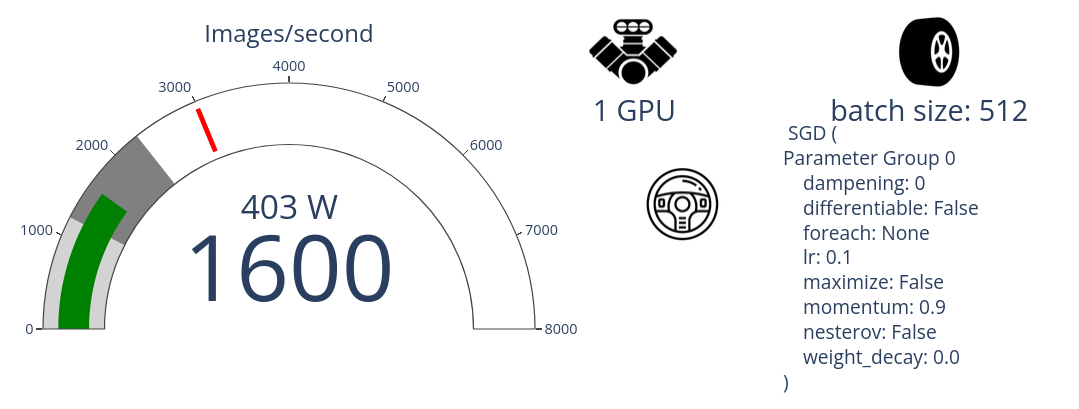

>**Task:** Modify the `train_pipeline.py` script, which outlines a standard training routine for a PyTorch model. In the model setup section, incorporate Torch.compile to enhance training efficiency. This adjustment is aimed at expediting training times and improving model performance across your hardware setup. After making the changes, return and run the code in the cell below to observe the improvements.

<details>
<summary>Solution (click to reveal)</summary>

```python
    model = torch.compile(model_raw, backend="inductor")
```
You should achieve a throughput around 2700. As for now, on Jean Zay for this code, only the inductor backend will work with mode default or reduce-overhead.
</details>


In [108]:
command = f'train_pipeline_solution.py -b 512 --image-size 224 --test'
jobid = gpu_jobs_submitter(command, n_gpu=1, module=MODULE, name=name,
                    account=account, time_max='00:10:00', constraint='a100', qos='qos_gpu-dev')
print(f'jobid = {jobid}')

batch job 0: 1 GPUs distributed on 1 nodes with 1 tasks / 1 gpus per node and 8 cpus per task
Submitted batch job 878148
jobid = ['878148']


Copier-coller la sortie `jobid = ['xxxxx']` dans la cellule suivante.

Puis, rebasculer la cellule précédente en mode `Raw NBConvert`, afin d'éviter de relancer un job par erreur.

In [109]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            878145    gpu_p5       kg  ssos023  R       4:10      1 jean-zay-iam04

 Done!


In [110]:
print("\nOut file:\n")
%cat {search_log(contains=jobid[0], with_err=True)['stdout'][0]}
print("\nError file:\n")
%cat {search_log(contains=jobid[0], with_err=True)['stderr'][0]}


Out file:

>>> Training on  1  nodes and  1  processes
model: Resnet-50
number of parameters: 25557032
global batch size: 512 - mini batch size: 512
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.1
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0
)
DATALOADER 16 True True True 3 False 
image batch shape : torch.Size([512, 3, 224, 224])
>>> Training complete in: 0:02:17.304236
>>> Training performance time: min 0.1791679859161377 avg 0.18086457252502441 seconds (+/- 0.0032872792284979243)
>>> Loading performance time: min 0.00021505355834960938 avg 0.0002942231236671915 seconds (+/- 5.681515971548064e-05)
>>> Forward performance time: 0.018890920950441946 seconds (+/- 0.0041290526632924195)
>>> Backward performance time: 0.15888285150333326 seconds (+/- 0.0029810683504140336)
>>> Peak Power during training: 415.501 W)
>>> Validation time: 0:00:41.718216
>>> Sortie trace ###########################

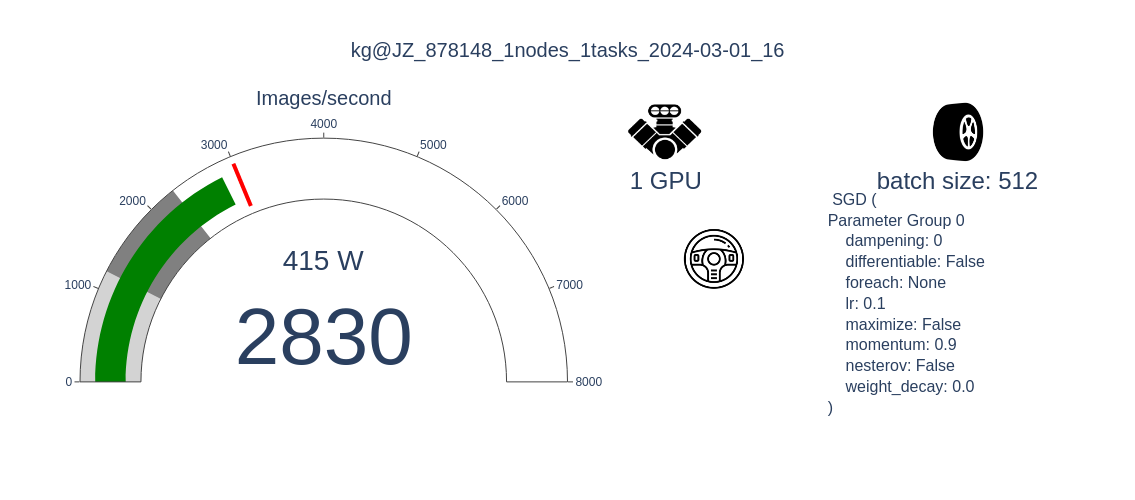

Train throughput: 2826.25 images/second
GPU throughput: 2830.85 images/second
epoch time: 453.44 seconds


UnboundLocalError: cannot access local variable 'val_time' where it is not associated with a value

In [111]:
controle_technique(jobid)

### Streamlining Training with Advanced Torch.compile Techniques



When enhancing your training setup with Torch.compile, incorporating it with Distributed Data Parallel (DDP) and the optimizer involves precise steps for optimal performance:

#### Integrating DDP with Torch.compile

Ensure DDP is applied before Torch.compile to maintain proper functionality across multiple GPUs:

```python
from torch.nn.parallel import DistributedDataParallel as DDP

model_ddp = DDP(model_raw)  # Wrap model with DDP
model = torch.compile(model_ddp, backend='inductor')  # Then compile
```

#### Compiling the Optimizer

With PyTorch 2.2.0+, optimizers can be compiled in an experimental feature to enhance the training loop. Wrap the optimizer step in a function and compile it for execution optimization:

```python
import torch

model = YourModel()  # Initialize your model
opt = torch.optim.Adam(model.parameters(), lr=0.01)  # Define the optimizer

@torch.compile(fullgraph=False)
def optimized_step():
    opt.step()  # Compile the optimizer step
```

> **Task:** After applying Torch.compile to your model in `train_pipeline.py`, try compiling the optimizer step as shown. This advanced, experimental technique aims to refine the training process further.

Leveraging these advanced Torch.compile strategies can significantly enhance the efficiency and speed of your model training, offering a cutting-edge approach to deep learning optimization.

---
---
### Enhancing Inference with Torch.compile



Torch.compile now offers an experimental feature that integrates with NVIDIA's TensorRT, a leading deep learning inference optimizer. This collaboration aims to boost inference performance on NVIDIA GPUs, utilizing TensorRT's capabilities for neural network optimization, including layer fusion and precision calibration. The goal is to markedly improve inference speed and efficiency, a crucial advantage for deployment in performance-sensitive production settings.

The synergy between TensorRT and Torch.compile simplifies achieving optimal inference speeds, making it easier to enhance model performance in critical production environments.

Additionally, it's important to select a backend that aligns with your specific hardware capabilities. For instance, Intel architectures can benefit from using the Intel Extension for PyTorch (IPEX), which optimizes performance on Intel CPUs. This tailored approach ensures that you leverage the best possible optimization techniques for your hardware, further enhancing inference efficiency and model responsiveness.